In [11]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import json
import torch
import gpytorch
import h5py
import collections
import scipy
import torch
import math
import seaborn as sns

from bnn_priors import prior

from bnn_priors.exp_utils import load_samples

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [2]:
if False:
    from bnn_priors.exp_utils import get_model

    model = get_model(torch.zeros((1, 28**2)), torch.zeros((1,), dtype=torch.int64)+9,
                  "datadrivendoublegammaconv", 64, 3, "datadrivencorrdoublegamma", 0,
                 0, "datadrivencorrdoublegamma", 0, 0, True,
                 {}, {})


In [3]:
if False:

    sd = []
    for i in range(11):
        model.sample_all_priors()
        sd.append(model.state_dict())

In [4]:
if False:

    prior_samples = {}
    for k in param_keys:
        l = []
        for s in sd:
            l.append(s[k])
        prior_samples[k] = torch.stack(l).numpy()

# Explore weights of the MNIST network, that doesn't have batchnorm

In [5]:
directories = [*map(str, range(8))]
samples = collections.defaultdict(lambda: [], {})
param_keys = None

for d in directories:
    with h5py.File(f"../logs/sgd-no-weight-decay/mnist_classificationconvnet/{d}/samples.pt", "r") as f:
        if param_keys is None:
            param_keys = [k for k in f.keys() if k.endswith(".p")]
            
        for key in param_keys:
            samples[key].append(f[key][-1])

In [6]:
for k in samples.keys():
    samples[k] = np.stack(samples[k])

In [7]:
samples.keys()

dict_keys(['net.module.1.bias_prior.p', 'net.module.1.weight_prior.p', 'net.module.4.bias_prior.p', 'net.module.4.weight_prior.p', 'net.module.8.bias_prior.p', 'net.module.8.weight_prior.p'])

In [8]:
samples_reshaped = {}
mean_covs = {}

for k in samples.keys():
    if k in ["net.module.1.weight_prior.p", "net.module.4.weight_prior.p"]:
        #if k == "net.module.8.weight_prior.p":
        #    samples_reshaped[k] = samples[k].transpose((0, 2, 1)).reshape((-1, 10))
        #else:
        samples_reshaped[k] = samples[k].reshape((-1, 9))
        mean_covs[k] = (np.mean(samples_reshaped[k], 0), np.cov(samples_reshaped[k], rowvar=False))
    else:
        samples_reshaped[k] = samples[k]    
        mean_covs[k] = (np.mean(samples[k]), np.var(samples[k]))

In [9]:
prior_samples_reshaped = {}
prior_mean_covs = {}

for k in samples.keys():
    if k in ["net.module.1.weight_prior.p", "net.module.4.weight_prior.p"]:
        #if k == "net.module.8.weight_prior.p":
        #    samples_reshaped[k] = samples[k].transpose((0, 2, 1)).reshape((-1, 10))
        #else:
        prior_samples_reshaped[k] = prior_samples[k].reshape((-1, 9))
        prior_mean_covs[k] = (np.mean(prior_samples_reshaped[k], 0), np.cov(prior_samples_reshaped[k], rowvar=False))
    else:
        prior_samples_reshaped[k] = prior_samples[k]    
        prior_mean_covs[k] = (np.mean(prior_samples[k]), np.var(prior_samples[k]))

NameError: name 'prior_samples' is not defined

In [ ]:
for k, (_, cov) in mean_covs.items():
    if isinstance(cov, float) or cov.shape == ():
        print(k, "empirical std.dev.", cov**.5, samples[k].shape)
    else:
        print(k, "empirical std.dev.", np.diag(cov).mean()**.5, "", samples[k].shape)

In [ ]:
#pd.to_pickle(mean_covs, "mean_covs.pkl.gz")

In [ ]:
_, axes = plt.subplots(4, 3, figsize=(12, 16))
for i, s in enumerate(samples["net.module.8.weight_prior.p"].reshape((11, -1))):
    axes.flat[i].hist(s, bins=40)
    axes.flat[i].set_title(f"network {i}, layer 1, bias hist.")

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
ax = axes[0]
key = "net.module.1.bias_prior.p"
dist = "burr12"

rvs = getattr(scipy.stats, dist).rvs(*fits_dict[key][dist], size=len(samples[key].flat))
heights, bins, _ = ax.hist(rvs, bins=40)
area = (bins[1:] - bins[:-1]) @ heights

x = np.linspace(samples[key].min(), samples[key].max(), 300)
y = getattr(scipy.stats, dist).pdf(x, *fits_dict[key][dist]) * area
ax.plot(x, y)
ax.set_title("Lay. 1 bias hist.")


ax = axes[1]
key = "net.module.4.bias_prior.p"
dist = "burr12"

rvs = getattr(scipy.stats, dist).rvs(*fits_dict[key][dist], size=len(samples[key].flat))
heights, bins, _ = ax.hist(rvs, bins=40)
area = (bins[1:] - bins[:-1]) @ heights

x = np.linspace(samples[key].min(), samples[key].max(), 300)
y = getattr(scipy.stats, dist).pdf(x, *fits_dict[key][dist]) * area
ax.plot(x, y)
ax.set_title("Lay. 2 bias hist.")


In [ ]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(samples["net.module.1.bias_prior.p"].flat, bins=40)
axes[0].set_title("Lay. 1 bias hist.")
axes[1].hist(samples["net.module.4.bias_prior.p"].flat, bins=40)
axes[1].set_title("Lay. 2 bias hist.")
axes[2].hist(samples["net.module.8.bias_prior.p"].flat, bins=30)
axes[2].set_title("Lay. 3 bias hist.")

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].hist(prior_samples["net.module.1.bias_prior.p"].flat, bins=40)
axes[0].set_title("Lay. 1 bias hist.")
axes[1].hist(prior_samples["net.module.4.bias_prior.p"].flat, bins=40)
axes[1].set_title("Lay. 2 bias hist.")
axes[2].hist(prior_samples["net.module.8.bias_prior.p"].flat, bins=30)
axes[2].set_title("Lay. 3 bias hist.")

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
for i in range(11):
    axes[0].plot(samples["net.module.1.bias_prior.p"][i])
    axes[1].plot(samples["net.module.4.bias_prior.p"][i])
    axes[2].plot(samples["net.module.8.bias_prior.p"][i])

axes[0].set_title("Lay. 1 biases")
axes[1].set_title("Lay. 2 biases")
axes[2].set_title("Lay. 3 biases")


In [ ]:
samples["net.module.1.weight_prior.p"].shape

In [ ]:
sns.set(context="paper", style="white", font_scale=1.5)

fig = plt.figure()

norm = Normalize(-0.27, 0.27)

ticks = [1, 3, 5, 7, 9]
tick_labels=["(1, 1)", "(1, 3)", "(2, 2)", "(3, 1)", "(3, 3)"]

ax = fig.add_axes(
    [0.0, 0.0, 0.6, 1.0],
    title="Layer 2 spatial covariance",
    yticks=range(1, 10),
    yticklabels=[f"({i//3+1}, {i%3+1})" for i in range(9)],
    xticks=ticks,
    xticklabels=tick_labels)

key = "net.module.4.weight_prior.p"
print(np.max(np.abs(mean_covs[key][1]*64)))
mappable = ax.imshow(mean_covs[key][1]*64, cmap=plt.get_cmap('RdBu'),
                     extent=[0.5, 9.5, 9.5, 0.5], norm=norm)

wsep = 0.01
height = 0.25

for axes_i, i in enumerate([1, 4, 6]):
    if axes_i == 2:
        bottom = 0
    else:
        bottom = (height + 0.1) * (2-axes_i)
    ax = fig.add_axes([0.6+wsep, bottom, height, height], xticks=[], yticks=[],
                      title=f"cov. with ({i//3 + 1}, {i%3+1})")
    ax.imshow(mean_covs[key][1][i, :].reshape((3, 3))*64,
              cmap=plt.get_cmap('RdBu'),
              extent=[0.5, 3.5, 3.5, 0.5], norm=norm)
    
cbar_ax = fig.add_axes([0.6+wsep+height+wsep, 0.0, 0.03, 1.0])
fig.colorbar(mappable, cax=cbar_ax)
plt.savefig("mnist_covariances_l2.pdf", bbox_inches='tight')

In [ ]:
sns.set(context="paper", style="white", font_scale=1.5)

fig = plt.figure()

ticks = [1, 3, 5, 7, 9]
tick_labels=["(1, 1)", "(1, 3)", "(2, 2)", "(3, 1)", "(3, 3)"]

ax = fig.add_axes(
    [0.0, 0.0, 0.6, 1.0],
    title="Layer 1 spatial covariance",
    yticks=range(1, 10),
    yticklabels=[f"({i//3+1}, {i%3+1})" for i in range(9)],
    xticks=ticks,
    xticklabels=tick_labels)

key = "net.module.1.weight_prior.p"
mappable = ax.imshow((mean_covs[key][1]), cmap=plt.get_cmap('RdBu'),
                     extent=[0.5, 9.5, 9.5, 0.5], norm=norm)

wsep = 0.01
height = 0.25

for axes_i, i in enumerate([1, 4, 6]):
    if axes_i == 2:
        bottom = 0
    else:
        bottom = (height + 0.1) * (2-axes_i)
    ax = fig.add_axes([0.6+wsep, bottom, height, height], xticks=[], yticks=[],
                      title=f"cov. with ({i//3 + 1}, {i%3+1})")
    ax.imshow(mean_covs[key][1][i, :].reshape((3, 3)),
              cmap=plt.get_cmap('RdBu'),
              extent=[0.5, 3.5, 3.5, 0.5], norm=norm)
    
#cbar_ax = fig.add_axes([0.6+wsep+height+wsep, 0.0, 0.03, 1.0])
#fig.colorbar(mappable, cax=cbar_ax)


plt.savefig("mnist_covariances_l1.pdf", bbox_inches='tight')

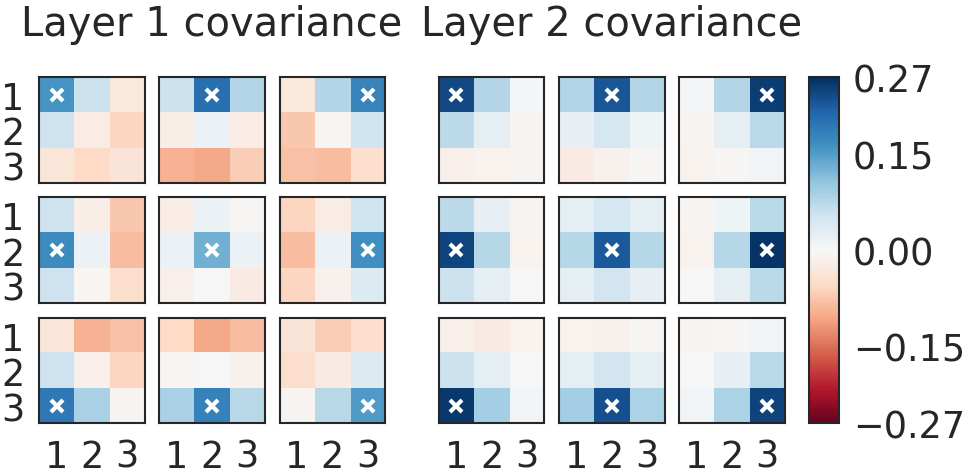

In [16]:
sns.set(context="paper", style="white", font_scale=1.0)
plt.rcParams["font.sans-serif"].insert(0, "DejaVu Sans")
plt.rcParams.update({
    "font.family": "sans-serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": True,     # don't setup fonts from rc parameters
    "font.size": 10,
    "axes.linewidth": 0.5,
    'ytick.major.width': 0.5,
    'ytick.major.size': 0,
    'xtick.major.width': 0.5,
    'xtick.major.size': 0,
    "figure.dpi": 300,

})

fig_width_pt = 234.8775
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

norm = Normalize(-0.27, 0.27)

margins = dict(
    left=0.04,
    right=0.1,
    top=0.08,
    bottom=0.05)

plots_x = 2
wsep = hsep = 0.015
w_cov_sep = 0.04
cbar_width = 0.03
cbar_wsep = 0.01
height = width = (1 - w_cov_sep*plots_x - wsep*3*plots_x - cbar_wsep - cbar_width
         - margins['left'] - margins['right'])/plots_x / 3
ttl_marg=10

fig_height_mult = (margins['bottom'] + height*3 + hsep*2 + margins['top'])

# make figure rectangular and correct vertical sizes
hsep /= fig_height_mult
height /= fig_height_mult
margins['bottom'] /= fig_height_mult
margins['top'] /= fig_height_mult

fig = plt.figure(figsize=(fig_width, fig_width *fig_height_mult))



cbar_height = height*3 + hsep*2

key = "net.module.1.weight_prior.p"

for y in range(3):
    for x in range(3):
        bottom = margins['bottom'] + (height + hsep) * (2-y)
        left = margins['left'] + (width +wsep) * x
        
        if x == 0:
            yticks = [1, 2, 3]
        else:
            yticks = []
            
        if y == 2:
            xticks = [1, 2, 3]
        else:
            xticks = []
        ax = fig.add_axes([left, bottom, width, height], xticks=xticks, yticks=yticks)
                          #title=f"cov. w/ ({x + 1}, {y +1})")
        ax.imshow(mean_covs[key][1][y*3+x, :].reshape((3, 3)),
                  cmap=plt.get_cmap('RdBu'),
                  extent=[0.5, 3.5, 3.5, 0.5], norm=norm)
        ax.plot([x+1], [y+1], marker='x', ls='none', color='white', ms=3)
        
        if y==0 and x==1:
            ttl = ax.set_title("Layer 1 covariance", pad=ttl_marg)


key = "net.module.4.weight_prior.p"

for y in range(3):
    for x in range(3):
        bottom = margins['bottom'] + (height + hsep) * (2-y)
        left = margins['left'] + (width+wsep)*3 + w_cov_sep + (width +wsep) * x
       
        yticks = []
            
        if y == 2: 
            xticks = [1, 2, 3]
        else:
            xticks = []
        ax = fig.add_axes([left, bottom, width, height], xticks=xticks, yticks=yticks)
                          #title=f"cov. w/ ({x + 1}, {y +1})")
        mappable = ax.imshow(mean_covs[key][1][y*3+x, :].reshape((3, 3))*64,
                  cmap=plt.get_cmap('RdBu'),
                  extent=[0.5, 3.5, 3.5, 0.5], norm=norm)
        ax.plot([x+1], [y+1], marker='x', ls='none', color='white', markersize=3)
        
        if y==0 and x==1:
            ttl = ax.set_title("Layer 2 covariance", pad=ttl_marg)
        
cbar_ax = fig.add_axes([margins['left'] + (width+wsep)*3*2 + w_cov_sep + cbar_wsep,
                        margins['bottom'], cbar_width, cbar_height])
fig.colorbar(mappable, cax=cbar_ax,
             ticks=[-0.27, -0.15, 0, 0.15, 0.27])
fig.savefig("../figures/210126-mnist-covariances-all.pdf")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
covs = {}
weights_reshaped = {}

ax = axes[0]
key = "net.module.1.weight_prior.p"
mappable = ax.imshow(prior_mean_covs[key][1], cmap=plt.get_cmap('viridis'))
fig.colorbar(mappable, ax=ax)
ax.set_title("Lay. 1 spatial cov.")

ax = axes[1]
key = "net.module.4.weight_prior.p"
mappable = ax.imshow(prior_mean_covs[key][1], cmap=plt.get_cmap('viridis'))
fig.colorbar(mappable, ax=ax)
ax.set_title("Lay. 2 spatial cov.")


In [ ]:
def plot_weightdist(weights, title=None, num_bins=50):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    #vmin = np.min([weight for weight in samples_reshaped.values()])
    #vmax = np.max([weight for weight in samples_reshaped.values()])
    #xlim = (vmin, vmax)
    for (name, weight), ax in zip(weights.items(), axes):
        sns.distplot(weight.flatten(), ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
        #gauss_pdf = make_pdf(stats.norm, stats.norm.fit(weight), start=xlim[0], end=xlim[1])
        #sns.lineplot(data=gauss_pdf, label="gaussian_fit", ax=ax)
        ax.legend(loc="upper right")
        #ax.set_xlim(xlim)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

plot_weightdist({"w1": samples_reshaped["net.module.1.weight_prior.p"],
                 "w2": samples_reshaped["net.module.4.weight_prior.p"]})

In [ ]:
samples_reshaped.keys()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharex=True)

whites = {}

ax = axes[0]
key = "net.module.1.weight_prior.p"
a = samples_reshaped[key] - mean_covs[key][0]
vals, vecs = np.linalg.eig(mean_covs[key][1])
whites[key] = a_white = a @ (vecs * vals**-.5)
ax.hist(a_white.flat, bins=40)
ax.set_title("Lay. 1 whitened weights")

ax = axes[1]
key = "net.module.4.weight_prior.p"
a = samples_reshaped[key] - mean_covs[key][0]
vals, vecs = np.linalg.eig(mean_covs[key][1])
whites[key] = a_white = a @ (vecs * vals**-.5)
ax.hist(a_white.flat, bins=40)
ax.set_title("Lay. 2 whitened weights")

In [ ]:
sorted_w = np.sort(whites[key].flatten())

x = np.stack([sorted_w]*2, axis=1).flatten()
y = np.stack([np.arange(0, len(sorted_w)), np.arange(1, len(sorted_w)+1)], axis=1).flatten()

plt.plot(x, y)

In [ ]:
plt.subplot(121)
plt.scatter(whites[ "net.module.1.weight_prior.p"][:len(whites[ "net.module.1.weight_prior.p"])//11, 0],
            whites[ "net.module.1.weight_prior.p"][:len(whites[ "net.module.1.weight_prior.p"])//11, 2])
plt.subplot(122)

plt.scatter(whites[ "net.module.1.weight_prior.p"][:len(whites[ "net.module.1.weight_prior.p"])//11, 0],
            whites[ "net.module.1.weight_prior.p"][:len(whites[ "net.module.1.weight_prior.p"])//11, 8])

In [ ]:
plt.subplot(121)
plt.scatter(whites[ "net.module.1.weight_prior.p"][:, 0],
            whites[ "net.module.1.weight_prior.p"][:, 2])
plt.subplot(122)

plt.scatter(whites[ "net.module.1.weight_prior.p"][:, 0],
            whites[ "net.module.1.weight_prior.p"][:, 8])

In [ ]:
plt.scatter(prior_whites[ "net.module.1.weight_prior.p"][:, 0],
            prior_whites[ "net.module.1.weight_prior.p"][:, 2])

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharex=True)

prior_whites = {}

ax = axes[0]
key = "net.module.1.weight_prior.p"
a = prior_samples_reshaped[key] - prior_mean_covs[key][0]
vals, vecs = np.linalg.eig(prior_mean_covs[key][1])
prior_whites[key] = a_white = a @ (vecs * vals**-.5)
ax.hist(a_white.flat, bins=40)
ax.set_title("Lay. 1 whitened weights")

ax = axes[1]
key = "net.module.4.weight_prior.p"
a = prior_samples_reshaped[key] - prior_mean_covs[key][0]
vals, vecs = np.linalg.eig(prior_mean_covs[key][1])
prior_whites[key] = a_white = a @ (vecs * vals**-.5)
ax.hist(a_white.flat, bins=40)
ax.set_title("Lay. 2 whitened weights")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
covs_big = {}

ax = axes[0]
key = "net.module.1.weight_prior.p"
a = samples[key].transpose((0, 2, 3, 4, 1)).reshape((99, -1))
covs_big[key] = a.T @ a / len(a)
mappable = ax.imshow(covs_big[key], cmap=plt.get_cmap('viridis'))
fig.colorbar(mappable, ax=ax)
ax.set_title("Lay. 1 filter-wise cov.")


ax = axes[1]
key = "net.module.4.weight_prior.p"
a = samples[key].transpose((0, 2, 3, 4, 1)).reshape((99, -1))
covs_big[key] = a.T @ a / len(a)
mappable = ax.imshow(covs_big[key], cmap=plt.get_cmap('viridis'))
fig.colorbar(mappable, ax=ax)
ax.set_title("Lay. 2 filter-wise cov.")

ax = axes[2]
key = "net.module.8.weight_prior.p"
a = samples[key].reshape((11*10, -1))
covs_big[key] = a.T @ a / len(a)
mappable = ax.imshow(covs_big[key], cmap=plt.get_cmap('viridis'))
fig.colorbar(mappable, ax=ax)
ax.set_title("Lay. 3 filter-wise cov.")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

key = "net.module.4.weight_prior.p"
a = samples[key].transpose((0, 2, 3, 4, 1)).reshape((99, -1))
covs[key] = a.T @ a / len(a)
mappable = ax.imshow(covs[key], cmap=plt.get_cmap('viridis'))
fig.colorbar(mappable, ax=ax)
plt.title("Layer 2 filter-wise cov")

# Fit any scipy.stats distribution to the biases

In [ ]:
from scipy.stats import rv_continuous

def fit_1d_dist(data, whitelist=None):
    fits = []
    data = data.ravel()
    if whitelist is None:
        whitelist = dir(scipy.stats)
    for attr in whitelist:
        try:
            dist_class = getattr(scipy.stats, attr)
            if isinstance(dist_class, rv_continuous) and attr != "levy_stable":
                args = dist_class.fit(data)
                likelihood = dist_class.logpdf(data, *args).sum()
                fits.append((attr, likelihood, args))
        except Exception as e:
            print(f"{attr} raised exception {e}")
            
    fits.sort(key=lambda x: -x[1])
    fits_dict = dict((name, args) for (name, _, args) in fits)
    return fits, fits_dict

In [ ]:
def plot_top_fits(data, fits, title, idx):
    data = data.ravel()

    _, ax = plt.subplots(1, 1, figsize=(10, 8))
    heights, bins, _ = ax.hist(data, bins=40)
    area = (bins[1:] - bins[:-1]) @ heights

    x = np.linspace(data.min(), data.max(), 5000)

    for attr, _, args in fits[idx]:
        y = getattr(scipy.stats, attr).pdf(x, *args) * area
        ax.plot(x, y, label=attr)
    ax.set_title(title)
    ax.legend()

In [ ]:
fits = {}
fits_dict = {}

In [ ]:
key = "net.module.1.bias_prior.p"
fits[key], fits_dict[key] = fit_1d_dist(samples[key], whitelist=["johnsonsu", "norminvgauss", "burr", "alpha", "gennorm", "nct", "burr12", "dgamma", "dweibull"])
plot_top_fits(samples[key], fits[key], "Layer 1 biases", slice(0, 10))

In [ ]:
key = "net.module.4.bias_prior.p"
fits[key], fits_dict[key] = fit_1d_dist(samples[key], whitelist=["norminvgauss", "burr", "alpha", "gennorm", "nct", "burr12", "dgamma", "dweibull"])
plot_top_fits(samples[key], fits[key], "Layer 2 biases", slice(0, 10))

In [ ]:
key = "net.module.8.bias_prior.p"
fits[key], fits_dict[key] = fit_1d_dist(samples[key], whitelist=["uniform"])
plot_top_fits(samples[key], new_fits, "Layer 3 biases", slice(0, 10))

# Fit whitened weights

In [ ]:
(0.6218022739172522*(1+0.6218022739172522))**-.5

In [ ]:
fits["net.module.4.weight_prior.p"][:4]

In [ ]:
whites["net.module.1.weight_prior.p"].mean()

In [ ]:
key = "net.module.1.weight_prior.p"
#fits[key], fits_dict[key] = fit_1d_dist(whites[key])
plot_top_fits(whites[key], fits[key], "Layer 1 white weights", slice(2, 6))

In [ ]:
key = "net.module.4.weight_prior.p"
#fits[key], fits_dict[key] = fit_1d_dist(whites[key], whitelist=["dgamma", "dweibull", "gennorm", "johnsonsu", "norminvgauss", "tukeylambda", "nct", "t", "laplace"])
plot_top_fits(whites[key], fits[key], "Layer 2 white weights", slice(0, 10))

In [ ]:
import math
math.sqrt(1/ (0.5818346034143134 * (1+ 0.5818346034143134)))

In [ ]:
fits["net.module.8.weight_prior.p"][0]

In [ ]:
fits["net.module.8.weight_prior.p"][0]

In [ ]:
key = "net.module.8.weight_prior.p"
this_whites = (samples[key] - mean_covs[key][0]) * mean_covs[key][1]**-.5

#fits[key], fits_dict[key] = fit_1d_dist(this_whites, whitelist=["dgamma", "laplace", "t", "gennorm"])
plot_top_fits(this_whites, fits[key], "Layer 3 white weights", slice(0, 5))

In [ ]:
fits_dict["net.module.8.weight_prior.p"]["dgamma"]

In [ ]:
pd.to_pickle((fits, fits_dict), "../bnn_priors/models/fits.pkl.gz")

# Fit the kernel matrix to the covariances

In [ ]:
class ConvFitter(torch.nn.Module):
    def __init__(self, kern, weights):
        super().__init__()
        self.inputs = torch.from_numpy(np.mgrid[:3, :3].reshape(2, -1).T.astype(np.float32))
        self.kern = kern
        #self.raw_std = torch.nn.Parameter(torch.randn(9))
        #self.raw_std_constraint = gpytorch.constraints.Positive()
        
        self.register_buffer("weights", torch.from_numpy(weights).to(self.inputs, copy=True))
        
        cov = self.weights.t() @ self.weights / len(self.weights)
        std = cov.diag()**.5
        self.weights /= std
        
        self.register_buffer("std", std)
        self.register_buffer("cov", cov)
                        
    def forward(self):
        #std = self.raw_std_constraint.transform(self.raw_std)
        #std = self.std
        #L = std.unsqueeze(-1) * self.kern(self.inputs).cholesky().evaluate()
        dist = gpytorch.distributions.MultivariateNormal(
            torch.zeros(len(self.inputs)), self.kern(self.inputs))
        return dist
    
    def closure(self):
        self.zero_grad()
        dist = self()
        loss = -dist.log_prob(self.weights).sum(0)
        loss.backward()
        return loss

In [ ]:
samples_reshaped.keys()

In [ ]:
opt_states = {}

for key in ['net.module.1.weight_prior.p', 'net.module.4.weight_prior.p']:
    max_lik = -np.inf
    for name, kern in [#("matern_12",gpytorch.kernels.MaternKernel(nu=1/2)),
                       #("matern_32",gpytorch.kernels.MaternKernel(nu=3/2)),
                       #("matern_52",gpytorch.kernels.MaternKernel(nu=5/2)),
                       ("rbf", gpytorch.kernels.RBFKernel())]:
        cf = ConvFitter(kern, samples_reshaped[key])
        optim = torch.optim.LBFGS(cf.parameters())
        for _ in range(10):
            loss = optim.step(cf.closure)
        ls = cf.kern.lengthscale.item()
        lik = -loss.item()
        
        if lik > max_lik:
            max_ls = ls
            max_lik = lik
            max_name = name
            max_sd = cf.state_dict()
            del max_sd["weights"]
    opt_states[key] = (max_name, max_sd)
    print(f"For {key}, {max_name} with ls={max_ls}")

In [ ]:
samples_reshaped

In [ ]:
_, axes = plt.subplots(2, 2, figsize=(10, 10))